Extraccion de datos de MONGODB PROCESAMIENTO

In [1]:
from pymongo import MongoClient
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import numpy as np
import matplotlib.pyplot as plt
import mysql.connector
from pymongo import MongoClient


In [2]:


# Conecto a la base de datos NO SQL Mongo
client = MongoClient("mongodb://localhost:27017/")
db = client.comments_db
collection = db.user_comments

# Cargo el modelo e sentimientos 
model_name = "tabularisai/multilingual-sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(model_name)
# Descarga la arquitectura y los pesos
model = AutoModelForSequenceClassification.from_pretrained(model_name)


print("Se cargó el modelo correctamente")
# Llamo a los comentarios que estan en el mongo db
comments = collection.find({})

Se cargó el modelo correctamente


Analisis de los datos y actualiza en MONGO DB EVALUACION/ENTRENAMIENTO

tensor([[0.1813, 0.7207, 0.0118, 0.0611, 0.0251]])
Comentario: '¡Qué torpe! El diseño del sitio web es poco intuitivo y fácil de usar.' -> Sentimiento: Negative con puntuación: 0.7206706404685974
tensor([[0.0320, 0.1036, 0.3506, 0.4776, 0.0362]])
Comentario: 'Estoy viendo la nueva serie de Netflix' -> Sentimiento: Positive con puntuación: 0.47757163643836975
tensor([[0.7650, 0.1820, 0.0139, 0.0198, 0.0193]])
Comentario: '¡Qué asco! No puedo creer que hayan hecho un producto tan malo.' -> Sentimiento: Very Negative con puntuación: 0.7649751901626587
tensor([[0.0146, 0.0123, 0.0100, 0.9051, 0.0579]])
Comentario: '¡Qué chiva! La presentación estuvo muy interesante, me mantuvo atento todo el tiempo.' -> Sentimiento: Positive con puntuación: 0.9051237106323242
tensor([[0.0176, 0.0280, 0.9222, 0.0167, 0.0154]])
Comentario: 'Hay un evento en el parque a las 5 p.m. si a alguien le interesa.' -> Sentimiento: Neutral con puntuación: 0.9222413897514343
tensor([[0.2955, 0.6334, 0.0168, 0.0349, 0.0

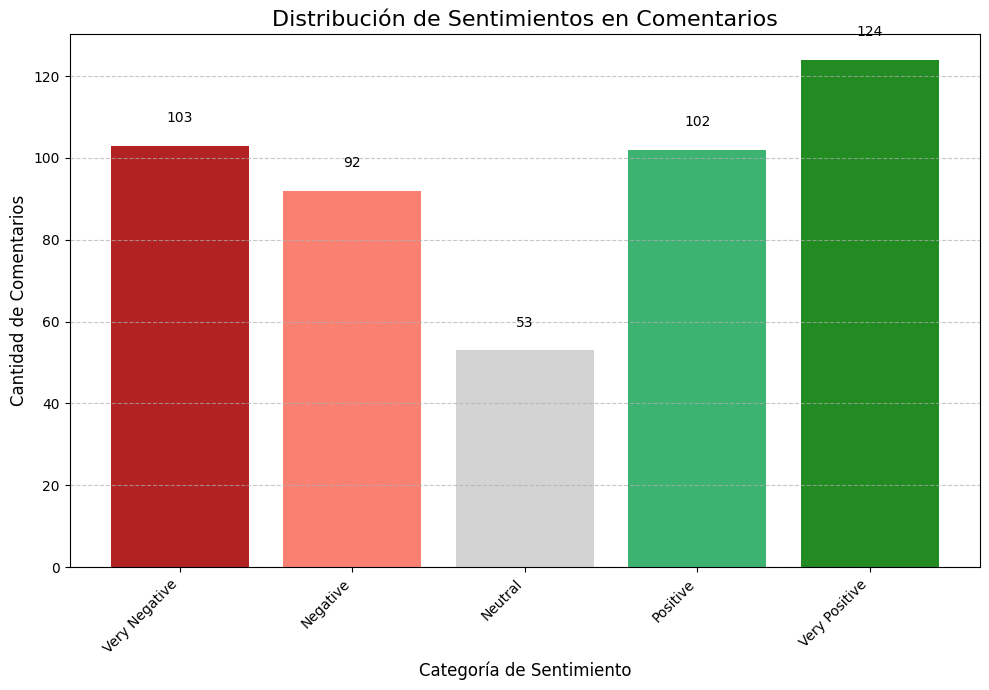

Análisis de sentimiento completado y base de datos actualizada.


In [3]:


# Diccionario para almacenar el recuento de cada sentimiento
sentiment_counts = {
    "Very Negative": 0,
    "Negative": 0,
    "Neutral": 0,
    "Positive": 0,
    "Very Positive": 0
}

def predict_sentiment_with_probabilities(texts):
    # Asegúrate de que el texto sea una lista para que el tokenizer funcione correctamente
    if isinstance(texts, str):
        texts = [texts]

    # Define la cantidad maxima de tokens que el modelo utilizara y le indica que el tensor es de pytorch
    inputs = tokenizer(texts, return_tensors="pt", truncation=True, padding=True, max_length=512)

    # No necesita calcular las gradientes ya que se trata de una prediccion o sea lo esta utilizando no ocupa realizar el entrenamiento ahorrando asi la memoria, luego desempaqueta el diccionario
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Aplico softmax para obtener la probabilidad
    probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
    
    print (probabilities)
    # Mapeo de índices a etiquetas de sentimientos
    sentiment_map = {0: "Very Negative", 1: "Negative", 2: "Neutral", 3: "Positive", 4: "Very Positive"}
    
    # Obtiene la etiqueta del sentimiento con la probabilidad más alta
    predicted_sentiments = [sentiment_map[p] for p in torch.argmax(probabilities, dim=-1).tolist()]
    
    # Creo los diccionarios 
    
    results = []
    for i, probs in enumerate(probabilities.tolist()):
        sentiment_probs = {
            "Very Negative": probs[0],
            "Negative": probs[1],
            "Neutral": probs[2],
            "Positive": probs[3],
            "Very Positive": probs[4]
        }
        results.append({
            "text": texts[i],
            "predicted_sentiment": predicted_sentiments[i],
            "probabilities": sentiment_probs
        })
        
    return results


for comment_doc in comments:
    comment_text = comment_doc.get("comment")


    # Asegúrate de que el campo de la etiqueta real existe
    real_sentiment = comment_doc.get("real_sentiment")

    if comment_text:
        # Separa el resultado con la predicción, el sentimiento y la puntuación
        result = predict_sentiment_with_probabilities(comment_text)[0]

      
        sentimiento_predicho = result['predicted_sentiment']
        probabilidades = result['probabilities'][result['predicted_sentiment']]
        sentiment_counts[sentimiento_predicho] += 1
        

        print(f"Comentario: '{comment_text}' -> Sentimiento: {sentimiento_predicho} con puntuación: {probabilidades}")

   
      # Agrego a la base de datos MongoDB el sentimiento y la puntuacion
        collection.update_one(
            {"_id": comment_doc["_id"]},
            {"$set": {"sentiment_label": sentimiento_predicho , "sentiment_score": probabilidades}}
        )


# Asumiendo que ya tienes el diccionario `sentiment_counts`
sentiments = list(sentiment_counts.keys())
counts = list(sentiment_counts.values())

# Define los colores para cada barra
colors = ['firebrick', 'salmon', 'lightgray', 'mediumseagreen', 'forestgreen']

plt.figure(figsize=(10, 7))

# Crea el gráfico de barras
plt.bar(sentiments, counts, color=colors)

# Títulos y etiquetas
plt.title('Distribución de Sentimientos en Comentarios', fontsize=16)
plt.xlabel('Categoría de Sentimiento', fontsize=12)
plt.ylabel('Cantidad de Comentarios', fontsize=12)
plt.xticks(rotation=45, ha='right') # Rota las etiquetas del eje X para que no se superpongan
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Muestra el valor exacto encima de cada barra
for i, count in enumerate(counts):
    plt.text(i, count + 5, str(count), ha='center', va='bottom')

plt.tight_layout() # Ajusta el diseño para que todo sea visible
plt.show()


print("Análisis de sentimiento completado y base de datos actualizada.")



Insertar en base de datos mysql

In [30]:



#  Paso los parametros de la base de datos mysql
MYSQL_HOST = "localhost"
MYSQL_USER = "user"
MYSQL_PASSWORD = "password"
MYSQL_DATABASE = "comments_db"
MYSQL_TABLE = "sentimientos"

try:
    # Realizo la conexion a la base de datos
    mysql_db = mysql.connector.connect(
      host=MYSQL_HOST,
      user=MYSQL_USER,
      password=MYSQL_PASSWORD
    )
    cursor = mysql_db.cursor()
    print("Conexión a MySQL exitosa.")

    #  Crear la base de datos si no existe
    cursor.execute(f"CREATE DATABASE IF NOT EXISTS {MYSQL_DATABASE}")
    print(f"Base de datos '{MYSQL_DATABASE}' verificada/creada.")

    # Selecciono la base de datos
    cursor.execute(f"USE {MYSQL_DATABASE}")
    
    # Si la tabla no existe la creo
    cursor.execute(f"""
        CREATE TABLE IF NOT EXISTS {MYSQL_TABLE} (
            comment_id VARCHAR(24) PRIMARY KEY,
             comment VARCHAR(2000),
            sentiment_label VARCHAR(50),
            sentiment_score DECIMAL(5, 4),
            fecha DATETIME)
    """)
    print(f"Tabla '{MYSQL_TABLE}' verificada/creada.")

    # --- Llamo los registros de la base de datos de mongodb
    client = MongoClient("mongodb://localhost:27017/")
    db = client["comments_db"]
    collection = db["user_comments"]

    comments = collection.find({})

    #  Inserto en la base de datos mysql los registros del mongo db
    for comment_doc in comments:
        comment_text = comment_doc.get("comment")
            
        if comment_text:
  
            
            sentiment = comment_doc.get("sentiment_label")
            score = comment_doc.get("sentiment_score") 
            comment_id = str(comment_doc["_id"])

            
      
     

            sql = f"INSERT INTO {MYSQL_TABLE} (comment_id,comment,sentiment_label, sentiment_score,fecha) VALUES (%s, %s, %s, %s, NOW())"
            values = (comment_id, comment_text, sentiment, score)

            
            try:
                cursor.execute(sql, values)
                mysql_db.commit()
                print(f"Datos insertados para el comentario con ID: {comment_id}")
            except mysql.connector.Error as err:
                print(f"Error al insertar datos en MySQL para el ID {comment_id}: {err}")
                mysql_db.rollback() 

except mysql.connector.Error as err:
    print(f"Error general al conectar o crear la base de datos/tabla: {err}")
finally:

    if 'cursor' in locals():
        cursor.close()
    if 'mysql_db' in locals():
        mysql_db.close()
    print("Proceso finalizado. Conexiones cerradas.")







Conexión a MySQL exitosa.
Base de datos 'comments_db' verificada/creada.
Tabla 'sentimientos' verificada/creada.
Datos insertados para el comentario con ID: 689b9e6a8808fbf8e6d0ffd1
Datos insertados para el comentario con ID: 689b9e6a8808fbf8e6d0ffd2
Datos insertados para el comentario con ID: 689b9e6a8808fbf8e6d0ffd3
Datos insertados para el comentario con ID: 689b9e6a8808fbf8e6d0ffd4
Datos insertados para el comentario con ID: 689b9e6a8808fbf8e6d0ffd5
Datos insertados para el comentario con ID: 689b9e6a8808fbf8e6d0ffd6
Datos insertados para el comentario con ID: 689b9e6a8808fbf8e6d0ffd7
Datos insertados para el comentario con ID: 689b9e6a8808fbf8e6d0ffd8
Datos insertados para el comentario con ID: 689b9e6a8808fbf8e6d0ffd9
Datos insertados para el comentario con ID: 689b9e6c8808fbf8e6d0ffda
Datos insertados para el comentario con ID: 689b9e718808fbf8e6d0ffdb
Datos insertados para el comentario con ID: 689b9e748808fbf8e6d0ffdc
Datos insertados para el comentario con ID: 689b9e788808fbf

In [39]:
print("\n--- Capas del modelo ---")
for name, layer in model.named_children():
    print(f"Capa: {name}")
    print(f"Arquitectura: {layer}")
    print("-" * 20)


--- Capas del modelo ---
Capa: distilbert
Arquitectura: DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(119547, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSdpaAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_featu